In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from itertools import product
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import mean_squared_error , r2_score
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Carrier,Item Quantity,City,Country,Status,Weight,Shipping Date,Delivery Date,Delivery Duration
0,A,2.0,Jeddah,SA,Delivered,0.0625,2021-09-30,2021-10-02,2
1,A,2.0,Madinah,SA,Delivered,0.3450,2021-09-30,2021-10-03,3
2,A,3.0,Makkah,SA,Delivered,2.1000,2021-09-30,2021-10-03,3
3,B,1.0,Riyadh,SA,Delivered,0.7000,2021-09-30,2021-10-03,3
4,B,2.0,Riyadh,SA,Delivered,1.4000,2021-09-30,2021-10-02,2


In [3]:
df.dtypes

Carrier               object
Item Quantity        float64
City                  object
Country               object
Status                object
Weight               float64
Shipping Date         object
Delivery Date         object
Delivery Duration      int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167056 entries, 0 to 167055
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Carrier            167056 non-null  object 
 1   Item Quantity      167055 non-null  float64
 2   City               167056 non-null  object 
 3   Country            167056 non-null  object 
 4   Status             167056 non-null  object 
 5   Weight             167056 non-null  float64
 6   Shipping Date      167056 non-null  object 
 7   Delivery Date      167056 non-null  object 
 8   Delivery Duration  167056 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 11.5+ MB


In [6]:
df.describe()

,Item Quantity,Weight,Delivery Duration
count,167055.000000,167056.000000,167056.000000
mean,3.027219,4.051167,1.504328
std,40.392914,9.518514,1.583442
min,1.000000,0.006000,0.000000
25%,1.000000,1.218000,1.000000
50%,2.000000,2.834000,1.000000
75%,3.000000,4.500000,2.000000
max,7800.000000,1874.400000,80.000000


In [3]:
df['Carrier'] = df['Carrier'].astype("category")
df['City'] = df['City'].astype("category")
df['Shipping Date'] =  pd.to_datetime(df['Shipping Date'])
df['Year'] = df['Shipping Date'].dt.year.astype("category")
df['Month'] = df['Shipping Date'].dt.month.astype("category")
df['Day'] = df['Shipping Date'].dt.day.astype("category")
df['DayOfWeek'] = df['Shipping Date'].dt.dayofweek.astype("category")

In [499]:
df.dtypes

Carrier                    category
Item Quantity               float64
City                       category
Country                      object
Status                       object
Weight                      float64
Shipping Date        datetime64[ns]
Delivery Date                object
Delivery Duration             int64
Year                       category
Month                      category
Day                        category
DayOfWeek                  category
dtype: object

In [4]:
df.drop(['Country', 'Status', 'Delivery Date','Item Quantity', 'Shipping Date'], axis=1, inplace=True)
df.head()

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
0,A,Jeddah,0.0625,2,2021,9,30,3
1,A,Madinah,0.3450,3,2021,9,30,3
2,A,Makkah,2.1000,3,2021,9,30,3
3,B,Riyadh,0.7000,3,2021,9,30,3
4,B,Riyadh,1.4000,2,2021,9,30,3


In [6]:
y = df['Delivery Duration']
X = df.drop('Delivery Duration', axis=1)

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [8]:
xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")


RMSE: 1.1542509919542023


In [9]:
df_pred = pd.DataFrame()
df_pred['preds'] = pd.Series(np.floor(xgb_preds)).replace({-1:0})
df_pred['true'] = y_test.values
df_pred

,preds,true
0,0.0,0
1,1.0,2
2,1.0,1
3,2.0,2
4,3.0,4
...,...,...
33407,3.0,4
33408,0.0,0
33409,0.0,0
33410,1.0,1


In [10]:
df_pred.true = df_pred.true.astype(str)

agg = df_pred[['true','preds']].groupby('true').agg(mean=('preds',np.mean),
                                             stdv=('preds',np.std),
                                              min=('preds',np.min),
                                              max=('preds',np.max),
                                             ).reset_index()
agg.true = agg.true.astype(int)
agg.sort_values('true')

,true,mean,stdv,min,max
0,0,0.145620,0.391323,0.0,6.0
1,1,0.766307,0.668236,0.0,26.0
12,2,1.466820,0.785104,0.0,13.0
16,3,1.999111,0.951864,0.0,8.0
18,4,2.440000,1.199975,0.0,8.0
19,5,2.745487,1.366821,0.0,8.0
21,6,3.177419,1.700433,0.0,9.0
22,7,3.490196,2.029771,0.0,9.0
23,8,4.070588,2.487053,0.0,8.0
24,9,3.280000,2.449823,0.0,10.0


In [15]:
# from sklearn.model_selection import GridSearchCV

# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.1],
#         'max_depth': [ 5, 7, 10],
#         'min_child_weight': [ 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [200, 500],
#     }
#     xgb_model = XGBRegressor(enable_categorical=True)

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,
#                            cv = 4,
#                            n_jobs = -1,
#                            )
#     gsearch.fit(X_train,y_train)
#     return gsearch.best_params_



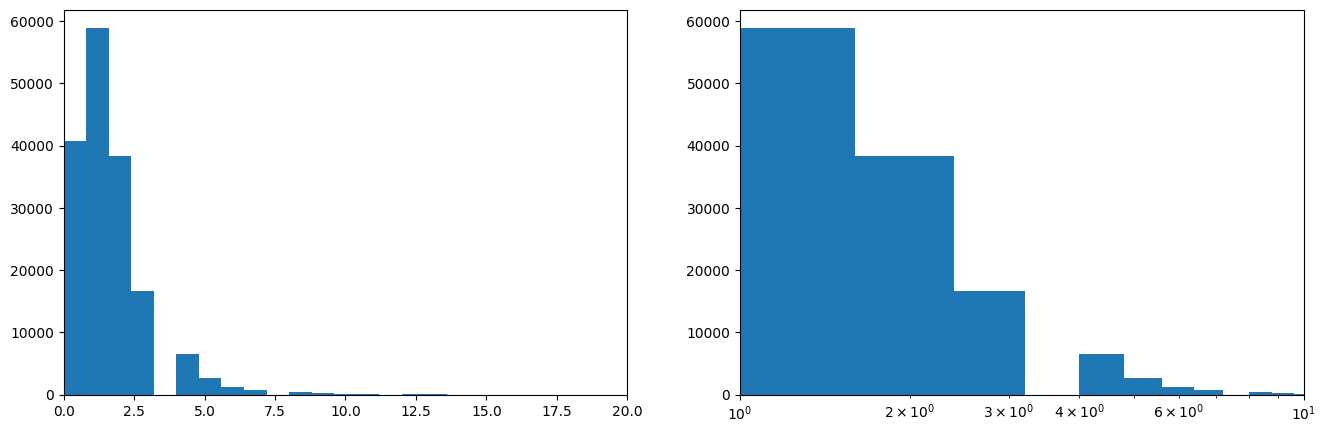

In [55]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=[16,5])

ax1.hist(df['Delivery Duration'],bins=100);
ax1.set(xlim=(0,20));

ax2.hist(df['Delivery Duration'],bins=100);
ax2.set(xscale='log', xlim=(1,10));

In [72]:
df[df['Delivery Duration'] <= 3].count()['City'], df[df['Delivery Duration'] > 3].count()['City']

(154607, 12449)

In [93]:
df_fast = df[df['Delivery Duration'] <= 3].copy()
df_slow = df[df['Delivery Duration'] > 3].copy()


In [86]:
y_f = df_fast['Delivery Duration']
X_f = df_fast.drop('Delivery Duration', axis=1)

In [87]:

X_train, X_test, y_train, y_test = train_test_split(
X_f, y_f, test_size=0.2, random_state=42)

In [88]:
xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")


RMSE: 0.6159738726023264


In [94]:
y_s = df_slow['Delivery Duration']
X_s = df_slow.drop('Delivery Duration', axis=1)

In [95]:

X_train, X_test, y_train, y_test = train_test_split(
X_s, y_s, test_size=0.2, random_state=42)

In [96]:
xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")


RMSE: 2.7586555835197917


In [98]:
df_med = df[(df['Delivery Duration'] > 3) & (df['Delivery Duration'] <= 7) ].copy()
y_m = df_med['Delivery Duration']
X_m = df_med.drop('Delivery Duration', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
X_m, y_m, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.8728234822501192


In [99]:
df_ss = df[(df['Delivery Duration'] > 7) ].copy()
y_ss = df_ss['Delivery Duration']
X_ss = df_ss.drop('Delivery Duration', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
X_ss, y_ss, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")


RMSE: 5.245974554480871


In [100]:
df_ss.count()

Carrier              1238
City                 1238
Weight               1238
Delivery Duration    1238
Year                 1238
Month                1238
Day                  1238
DayOfWeek            1238
dtype: int64

In [101]:
df_ss['Delivery Duration'].value_counts()

Delivery Duration
8     408
9     223
10    176
11    122
12     97
13     55
14     26
15     21
18     19
16     17
17     17
19     10
21      9
24      6
23      5
20      5
35      3
29      2
33      2
22      2
27      1
80      1
41      1
77      1
25      1
28      1
36      1
39      1
57      1
50      1
26      1
56      1
45      1
Name: count, dtype: int64

In [103]:
df['Delivery Duration'].value_counts()

Delivery Duration
1     58897
0     40770
2     38303
3     16637
4      6482
5      2631
6      1308
7       790
8       408
9       223
10      176
11      122
12       97
13       55
14       26
15       21
18       19
16       17
17       17
19       10
21        9
24        6
23        5
20        5
35        3
33        2
29        2
22        2
41        1
27        1
80        1
77        1
25        1
39        1
36        1
57        1
28        1
50        1
26        1
56        1
45        1
Name: count, dtype: int64

In [107]:
df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
0,A,Jeddah,0.0625,2,2021,9,30,3
1,A,Madinah,0.3450,3,2021,9,30,3
2,A,Makkah,2.1000,3,2021,9,30,3
3,B,Riyadh,0.7000,3,2021,9,30,3
4,B,Riyadh,1.4000,2,2021,9,30,3
...,...,...,...,...,...,...,...,...
167051,A,Riyadh,1.2180,1,2023,10,11,2
167052,A,Madinah,4.7560,4,2023,10,11,2
167053,A,Makkah,1.2180,2,2023,10,11,2
167054,A,Jeddah,4.7560,4,2023,10,11,2


In [113]:
y = df['Delivery Duration']
X = df.drop('Delivery Duration', axis=1)

In [116]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1542509919542023


In [117]:
# from sklearn.utils import resample

# time_4 = df[(df['Delivery Duration'] == 4)]
# time_5 = df[(df['Delivery Duration'] == 5)]
# time_6 = df[(df['Delivery Duration'] == 6)]
# time_7 = df[(df['Delivery Duration'] == 7)]

# avgtime = df.loc[~((df['Delivery Duration'] == 4) | (df['Delivery Duration'] == 5) | (df['Delivery Duration'] == 6) | (df['Delivery Duration'] == 7))]

# upsampled_time_4 = resample(time_4,
#                              replace=True,
#                              n_samples=8000)


# upsampled_time_5 = resample(time_5,
#                              replace=True,
#                              n_samples=4000)


# upsampled_time_6 = resample(time_6,
#                              replace=True,
#                              n_samples=3000)


# upsampled_time_7 = resample(time_7,
#                              replace=True,
#                              n_samples=1000)

In [119]:
df_med['Delivery Duration'].value_counts()

Delivery Duration
4    6482
5    2631
6    1308
7     790
Name: count, dtype: int64

In [121]:
df[df['Delivery Duration'] <= 7]['Delivery Duration'].value_counts()

Delivery Duration
1    58897
0    40770
2    38303
3    16637
4     6482
5     2631
6     1308
7      790
Name: count, dtype: int64

In [156]:
from sklearn.utils import resample

df_avg = df[df['Delivery Duration'] <= 7].copy()

time_4 = df_avg[(df_avg['Delivery Duration'] == 4)]
time_5 = df_avg[(df_avg['Delivery Duration'] == 5)]
time_6 = df_avg[(df_avg['Delivery Duration'] == 6)]
time_7 = df_avg[(df_avg['Delivery Duration'] == 7)]

fast = df_avg[df_avg['Delivery Duration'] < 4]

upsampled_time_4 = resample(time_4,
                             replace=True,
                             n_samples=8000)


upsampled_time_5 = resample(time_5,
                             replace=True,
                             n_samples=6000)


upsampled_time_6 = resample(time_6,
                             replace=True,
                             n_samples=3000)


upsampled_time_7 = resample(time_7,
                             replace=True,
                             n_samples=1000)


In [184]:
new_df = pd.concat([upsampled_time_4,upsampled_time_5,upsampled_time_6,upsampled_time_7,fast],axis=0)
new_df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
150347,K,Riyadh,0.970,4,2023,9,21,3
142197,AA,Riyadh,1.320,4,2023,10,4,2
143396,B,Madinah,0.330,4,2023,10,2,0
149984,B,Madinah,9.000,4,2023,9,23,5
115310,X,Madinah,0.330,4,2023,8,8,1
...,...,...,...,...,...,...,...,...
167049,A,Riyadh,15.196,1,2023,10,11,2
167050,K,Riyadh,0.970,1,2023,10,11,2
167051,A,Riyadh,1.218,1,2023,10,11,2
167053,A,Makkah,1.218,2,2023,10,11,2


In [185]:
new_df['Delivery Duration'].value_counts()

Delivery Duration
1    58897
0    40770
2    38303
3    16637
4     8000
5     6000
6     3000
7     1000
Name: count, dtype: int64

In [186]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)

In [187]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.9241985888837344


In [188]:
df_pred = pd.DataFrame()
df_pred['preds'] = xgb_preds
df_pred['true'] = y_test.values
df_pred

,preds,true
0,0.726969,0
1,2.252764,2
2,0.443804,0
3,0.210877,2
4,0.887450,1
...,...,...
34517,1.322317,1
34518,1.419415,1
34519,6.107157,7
34520,2.383820,3


In [189]:
X_test

,Carrier,City,Weight,Year,Month,Day,DayOfWeek
87755,V,Riyadh,2.834,2023,1,2,0
86432,R,Jeddah,4.500,2023,1,5,3
109254,V,Riyadh,2.560,2023,5,15,0
30600,I,Riyadh,0.295,2022,2,6,6
160754,AA,Riyadh,5.200,2023,10,21,5
...,...,...,...,...,...,...,...
14269,F,Riyadh,4.095,2021,12,16,3
38447,P,Riyadh,4.756,2022,7,3,6
100564,K,Jeddah,2.560,2023,6,26,0
111327,S,Madinah,4.500,2023,5,1,0


In [161]:
y = df_avg['Delivery Duration']
X = df_avg.drop('Delivery Duration', axis=1)

In [162]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.8524072532376933


In [211]:
df_avg.Carrier.value_counts().sum()

165818

In [205]:
(df_avg.Carrier.value_counts() >= 10000).loc['V':'S'].index

CategoricalIndex(['V', 'B', 'W', 'H', 'K', 'D', 'F', 'S'], categories=['A', 'AA', 'B', 'BB', ..., 'W', 'X', 'Y', 'Z'], ordered=False, dtype='category', name='Carrier')

In [216]:
ls_df = []
for i in df_avg.Carrier.unique():
    carrier_df = df_avg[df_avg['Carrier'] == i]
    if len(carrier_df) < 10000 and len(carrier_df) >= 5000:
        upsampled_data = resample(carrier_df,
                  replace=True,
              n_samples=10000)
        ls_df.append(upsampled_data)
    elif len(carrier_df) < 5000 and len(carrier_df) >= 1000:
        upsampled_data = resample(carrier_df,
                                  replace=True,
                                  n_samples=6000)
        ls_df.append(upsampled_data)
    elif len(carrier_df) < 1000:
        upsampled_data = resample(carrier_df,
                                  replace=True,
                                  n_samples=3000)
        ls_df.append(upsampled_data)

In [218]:
famous = ['V', 'B', 'W', 'H', 'K', 'D', 'F', 'S']
new_df = pd.concat([*ls_df, df_avg.query('Carrier in @famous')],axis=0)
new_df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
149820,A,Riyadh,12.586,3,2023,9,24,6
66024,A,Riyadh,0.820,0,2022,12,21,2
15249,A,Jeddah,0.900,3,2021,12,4,5
58749,A,Madinah,2.272,2,2022,8,28,6
61354,A,Jeddah,1.120,0,2022,8,7,6
...,...,...,...,...,...,...,...,...
167045,K,Riyadh,0.970,1,2023,10,11,2
167046,K,Makkah,0.970,1,2023,10,11,2
167047,K,Riyadh,0.970,1,2023,10,11,2
167048,K,Makkah,0.970,1,2023,10,11,2


In [219]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)

In [11]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1542509919542023


In [12]:
df_pred = pd.DataFrame()
df_pred['preds'] = xgb_preds
df_pred['true'] = y_test.values
df_pred

,preds,true
0,0.551989,0
1,1.917566,2
2,1.376063,1
3,2.079146,2
4,3.194570,4
...,...,...
33407,3.962178,4
33408,0.844526,0
33409,0.462317,0
33410,1.556597,1


In [223]:
df.Carrier.value_counts()

Carrier
V     18385
B     16430
W     16023
K     14219
H     13878
D     13597
F     13392
S     11679
A      8753
R      7142
P      6845
I      4690
G      3609
X      3223
AA     3171
Y      2840
O      2313
E      1868
C      1641
L      1394
Z       641
M       465
CC      238
J       220
BB      148
DD       94
Q        68
N        68
T        13
U         9
Name: count, dtype: int64

In [226]:
ls_df = []
for i in df_avg.Carrier.unique():
    carrier_df = df[df['Carrier'] == i]
    if len(carrier_df) < 10000 and len(carrier_df) >= 5000:
        upsampled_data = resample(carrier_df,
                  replace=True,
              n_samples=10000)
        ls_df.append(upsampled_data)
        
    elif len(carrier_df) < 5000 and len(carrier_df) >= 1000:
        upsampled_data = resample(carrier_df,
                                  replace=True,
                                  n_samples=6000)
        ls_df.append(upsampled_data)
        
    elif len(carrier_df) < 1000:
        upsampled_data = resample(carrier_df,
                                  replace=True,
                                  n_samples=3000)
        ls_df.append(upsampled_data)

In [228]:
famous = ['V', 'B', 'W', 'H', 'K', 'D', 'F', 'S']
new_df = pd.concat([*ls_df, df.query('Carrier in @famous')],axis=0)
new_df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
69936,A,Jeddah,1.120,0,2022,12,5,0
28900,A,Makkah,35.000,3,2022,2,23,2
64755,A,Jeddah,0.820,0,2022,12,27,1
148434,A,Riyadh,15.391,3,2023,9,26,1
66761,A,Makkah,0.820,0,2022,12,18,6
...,...,...,...,...,...,...,...,...
167045,K,Riyadh,0.970,1,2023,10,11,2
167046,K,Makkah,0.970,1,2023,10,11,2
167047,K,Riyadh,0.970,1,2023,10,11,2
167048,K,Makkah,0.970,1,2023,10,11,2


In [230]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)

In [231]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1428751597998281


In [235]:
y = df['Delivery Duration']
X = df.drop('Delivery Duration', axis=1)

In [236]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1542509919542023


In [239]:
ls_df = []
for i in range(4,81):
    if i in list(df['Delivery Duration'].value_counts().index):
        duration_df = df[df['Delivery Duration'] == i]
        if len(duration_df) < 10000 and len(duration_df) >= 5000:
            upsampled_data = resample(duration_df,
                      replace=True,
                  n_samples=10000)
            ls_df.append(upsampled_data)
            
        elif len(duration_df) < 5000 and len(duration_df) >= 1000:
            upsampled_data = resample(duration_df,
                                      replace=True,
                                      n_samples=6000)
            ls_df.append(upsampled_data)

        elif len(duration_df) < 1000:
            upsampled_data = resample(duration_df,
                                      replace=True,
                                      n_samples=3000)
            ls_df.append(upsampled_data)


In [251]:
new_df = pd.concat([*ls_df, df[df['Delivery Duration'] <= 3]],axis=0)
new_df
# df['Delivery Duration'].value_counts()

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
37021,P,Riyadh,3.472,4,2022,7,14,3
86355,R,Dammam,4.500,4,2023,1,5,3
150880,A,Jeddah,4.500,4,2023,9,20,2
49191,F,Riyadh,2.560,4,2022,10,6,3
113864,X,Makkah,0.410,4,2023,8,9,2
...,...,...,...,...,...,...,...,...
167049,A,Riyadh,15.196,1,2023,10,11,2
167050,K,Riyadh,0.970,1,2023,10,11,2
167051,A,Riyadh,1.218,1,2023,10,11,2
167053,A,Makkah,1.218,2,2023,10,11,2


In [256]:
ls_df = []
for i in df_avg.Carrier.unique():
    carrier_df = new_df[new_df['Carrier'] == i]
    if len(carrier_df) < 10000 and len(carrier_df) >= 5000:
        upsampled_data = resample(carrier_df,
                  replace=True,
              n_samples=10000)
        ls_df.append(upsampled_data)
    elif len(carrier_df) < 5000 and len(carrier_df) >= 1000:
        upsampled_data = resample(carrier_df,
                                  replace=True,
                                  n_samples=6000)
        ls_df.append(upsampled_data)
    elif len(carrier_df) < 1000:
        upsampled_data = resample(carrier_df,
                                  replace=True,
                                  n_samples=3000)
        ls_df.append(upsampled_data)

In [258]:
famous = ['V', 'B', 'W', 'H', 'K', 'D', 'F', 'S', 'D', 'R', 'H', 'P','G']
new_df = pd.concat([*ls_df, new_df.query('Carrier in @famous')],axis=0)
new_df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
5344,C,Madinah,1.000,1,2021,8,29,6
9539,C,Jeddah,0.700,9,2021,7,18,6
19308,C,Dammam,0.700,1,2021,10,30,5
8223,C,Makkah,2.580,2,2021,8,2,0
102,C,Madinah,0.379,3,2021,9,30,3
...,...,...,...,...,...,...,...,...
167045,K,Riyadh,0.970,1,2023,10,11,2
167046,K,Makkah,0.970,1,2023,10,11,2
167047,K,Riyadh,0.970,1,2023,10,11,2
167048,K,Makkah,0.970,1,2023,10,11,2


In [266]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)

In [273]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, np.floor(xgb_preds), squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1862121419796543


In [275]:
y = df['Delivery Duration']
X = df.drop('Delivery Duration', axis=1)

In [277]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1542509919542023


In [274]:
df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
0,A,Jeddah,0.0625,2,2021,9,30,3
1,A,Madinah,0.3450,3,2021,9,30,3
2,A,Makkah,2.1000,3,2021,9,30,3
3,B,Riyadh,0.7000,3,2021,9,30,3
4,B,Riyadh,1.4000,2,2021,9,30,3
...,...,...,...,...,...,...,...,...
167051,A,Riyadh,1.2180,1,2023,10,11,2
167052,A,Madinah,4.7560,4,2023,10,11,2
167053,A,Makkah,1.2180,2,2023,10,11,2
167054,A,Jeddah,4.7560,4,2023,10,11,2


In [278]:
df

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
0,A,Jeddah,0.0625,2,2021,9,30,3
1,A,Madinah,0.3450,3,2021,9,30,3
2,A,Makkah,2.1000,3,2021,9,30,3
3,B,Riyadh,0.7000,3,2021,9,30,3
4,B,Riyadh,1.4000,2,2021,9,30,3
...,...,...,...,...,...,...,...,...
167051,A,Riyadh,1.2180,1,2023,10,11,2
167052,A,Madinah,4.7560,4,2023,10,11,2
167053,A,Makkah,1.2180,2,2023,10,11,2
167054,A,Jeddah,4.7560,4,2023,10,11,2


In [279]:
df_fast = df[df['Delivery Duration'] <= 3].copy()
df_slow = df[df['Delivery Duration'] > 3].copy()


In [281]:
df_fast.Carrier.unique(), df_slow.Carrier.unique()

(['A', 'B', 'C', 'D', 'E', ..., 'Z', 'AA', 'BB', 'CC', 'DD']
 Length: 30
 Categories (30, object): ['A', 'AA', 'B', 'BB', ..., 'W', 'X', 'Y', 'Z'],
 ['B', 'D', 'E', 'A', 'G', ..., 'Y', 'Z', 'AA', 'T', 'CC']
 Length: 28
 Categories (30, object): ['A', 'AA', 'B', 'BB', ..., 'W', 'X', 'Y', 'Z'])

In [284]:
df.Carrier.value_counts()

Carrier
V     18385
B     16430
W     16023
K     14219
H     13878
D     13597
F     13392
S     11679
A      8753
R      7142
P      6845
I      4690
G      3609
X      3223
AA     3171
Y      2840
O      2313
E      1868
C      1641
L      1394
Z       641
M       465
CC      238
J       220
BB      148
DD       94
Q        68
N        68
T        13
U         9
Name: count, dtype: int64

In [285]:
import seaborn as sns

C:\Users\ENG_Aaref\anaconda3\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\ENG_Aaref\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


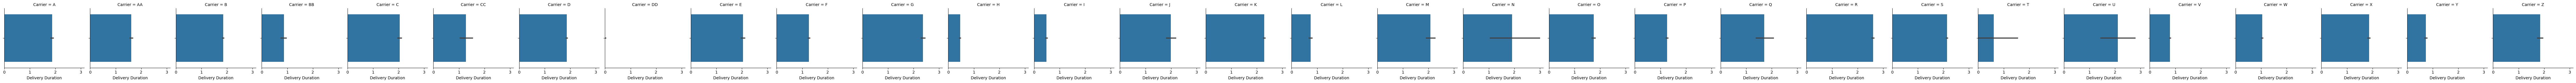

In [289]:
g = sns.FacetGrid(df, col='Carrier')
g.map(sns.barplot, 'Delivery Duration')

In [305]:
df[['Delivery Duration', 'Carrier']].groupby('Carrier').agg(count_value = ('Delivery Duration', len),
                                                            mean_value = ('Delivery Duration', np.mean),
                                                            std_value = ('Delivery Duration', np.std),
                                                           min_value = ('Delivery Duration', np.min),
                                                           max_value = ('Delivery Duration', np.max),).sort_values('count_value')

,count_value,mean_value,std_value,min_value,max_value
Carrier,,,,,
U,9,2.111111,1.166667,1,4
T,13,0.615385,1.502135,0,4
Q,68,1.705882,1.282009,1,4
N,68,1.911765,4.127575,0,13
DD,94,0.010638,0.103142,0,1
BB,148,0.864865,0.635124,0,3
J,220,1.990909,1.417409,0,11
CC,238,1.268908,1.854166,0,19
M,465,2.075269,1.847858,0,21


In [321]:
df_20 = df[df['Delivery Duration'] > 20][['Carrier', 'Weight']].copy()
df_20.groupby('Carrier').agg(mean_dur = ('Weight', np.mean),
                                         sum_dur = ('Weight', np.sum),
                                         count_dur = ('Weight', len)).dropna().reset_index()

,Carrier,mean_dur,sum_dur,count_dur
0,A,19.750400,98.752,5
1,B,1.940000,7.760,4
2,D,2.375500,4.751,2
3,F,4.864000,14.592,3
4,G,6.560000,19.680,3
5,K,5.256429,36.795,7
6,M,0.592000,0.592,1
7,O,1.218000,1.218,1
8,P,8.878000,8.878,1
9,R,4.786000,23.930,5


In [320]:
df[df['Delivery Duration'] > 20]

,Carrier,City,Weight,Delivery Duration,Year,Month,Day,DayOfWeek
355,D,Jeddah,0.251,35,2021,9,29,2
6951,M,Dammam,0.592,21,2021,8,10,1
15052,F,Riyadh,4.000,23,2021,12,5,6
18869,A,Makkah,41.800,23,2021,11,1,0
24766,A,Dammam,30.392,22,2022,3,27,6
24771,G,Jeddah,12.090,56,2022,3,27,6
32881,A,Dammam,20.000,29,2022,1,16,6
38901,F,Riyadh,8.200,23,2022,6,29,2
39025,K,Makkah,4.756,26,2022,6,28,1
39608,F,Riyadh,2.392,50,2022,6,18,5


In [362]:
ls_df = []
for i in df['Delivery Duration'].unique():
    dur_df = df[df['Delivery Duration'] == i]
    if len(dur_df) < 1000:
        upsampled_data = resample(dur_df,
                  replace=True,
              n_samples=int(100 + len(dur_df)))
        ls_df.append(upsampled_data)

In [363]:
new_df = pd.concat([*ls_df, df[df['Delivery Duration']<=3]],axis=0)

In [364]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, np.floor(xgb_preds), squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.005093959670985


In [365]:
y = df['Delivery Duration']
X = df.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, np.floor(xgb_preds), squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.2815630794982003


In [354]:
df['Delivery Duration'].value_counts()

Delivery Duration
1     58897
0     40770
2     38303
3     16637
4      6482
5      2631
6      1308
7       790
8       408
9       223
10      176
11      122
12       97
13       55
14       26
15       21
18       19
16       17
17       17
19       10
21        9
24        6
23        5
20        5
35        3
33        2
29        2
22        2
41        1
27        1
80        1
77        1
25        1
39        1
36        1
57        1
28        1
50        1
26        1
56        1
45        1
Name: count, dtype: int64

In [366]:
df_fast = df[df['Delivery Duration'] <= 7].copy()
df_slow = df[df['Delivery Duration'] > 7].copy()


In [370]:
y = df_fast['Delivery Duration']
X = df_fast.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, np.floor(xgb_preds), squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.015217110855329


In [381]:
y = df_slow['Delivery Duration']
X = df_slow.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 5.245974554480871


In [470]:
df_fast['Delivery Duration'].value_counts()

Delivery Duration
1    58897
0    40770
2    38303
3    16637
4     6482
5     2631
6     1308
7      790
Name: count, dtype: int64

In [473]:
y = df_fast['Delivery Duration']
X = df_fast.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, np.floor(xgb_preds), squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.015217110855329


In [494]:
df_pred = pd.DataFrame()
df_pred['preds'] = np.floor(xgb_preds)
df_pred['preds'] = df_pred['preds'].replace({-1:0})
df_pred['true'] = y_test.values
df_pred['err'] = np.absolute(df_pred['true'] - df_pred['preds'])
for i in X_test.columns: 
    df_pred[i] = X_test[i].values
df_pred

,preds,true,err,Carrier,City,Weight,Year,Month,Day,DayOfWeek
0,0.0,0,0.0,W,Riyadh,2.560,2023,5,24,2
1,1.0,1,0.0,C,Madinah,2.500,2021,8,29,6
2,1.0,1,0.0,B,Makkah,4.500,2023,8,30,2
3,1.0,1,0.0,AA,Riyadh,1.780,2023,9,5,1
4,1.0,1,0.0,V,Riyadh,4.500,2023,4,13,3
...,...,...,...,...,...,...,...,...,...,...
33159,0.0,1,1.0,W,Riyadh,5.200,2023,9,5,1
33160,0.0,1,1.0,B,Jeddah,4.756,2023,7,16,6
33161,1.0,4,3.0,B,Madinah,0.330,2023,8,29,1
33162,2.0,2,0.0,B,Makkah,0.280,2023,8,1,1


In [495]:
df_pred.true = df_pred.true.astype(str)
df_pred[['true','preds']].groupby('true').agg(mean=('preds',np.mean),
                                             stdv=('preds',np.std),
                                              min=('preds',np.min),
                                              max=('preds',np.max),
                                             )

,mean,stdv,min,max
true,,,,
0,0.128866,0.348362,0.0,3.0
1,0.740577,0.545264,0.0,4.0
2,1.402866,0.702052,0.0,4.0
3,1.902292,0.861151,0.0,5.0
4,2.333587,1.077441,0.0,5.0
5,2.581921,1.241717,0.0,5.0
6,2.772549,1.390077,0.0,6.0
7,3.029412,1.607771,0.0,6.0


In [488]:
df_pred.true = df_pred.true.astype(str)
df_pred[['true','err']].groupby('true').agg(mean=('err',np.mean),
                                             stdv=('err',np.std),
                                              min=('err',np.min),
                                              max=('err',np.max),
                                             )

,mean,stdv,min,max
true,,,,
0,0.128866,0.348362,0.0,3.0
1,0.360674,0.484275,0.0,3.0
2,0.658893,0.644435,0.0,2.0
3,1.133896,0.812896,0.0,3.0
4,1.684650,1.048675,0.0,4.0
5,2.418079,1.241717,0.0,5.0
6,3.227451,1.390077,0.0,6.0
7,3.970588,1.607771,1.0,7.0


In [462]:
ls_df = []
for i in df_fast['Delivery Duration'].unique():
    dur_df = df_fast[df_fast['Delivery Duration'] == i]
    if len(dur_df) < 10000:
        upsampled_data = resample(dur_df,
                  replace=True,
              n_samples=int(1000 + len(dur_df)))
        ls_df.append(upsampled_data)

In [463]:
new_df = pd.concat([*ls_df, df_fast[df_fast['Delivery Duration'] <=3 ]],axis=0)

In [464]:
new_df['Delivery Duration'].value_counts()

Delivery Duration
1    58897
0    40770
2    38303
3    16637
4     7482
5     3631
6     2308
7     1790
Name: count, dtype: int64

In [466]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.9055429980688259


In [469]:
y_test.mean()

1.523083264633141

In [450]:
ls_df = []
for i in df_slow['Delivery Duration'].unique():
    dur_df = df_slow[df_slow['Delivery Duration'] == i]
    if len(dur_df) < 50:
        upsampled_data = resample(dur_df,
                  replace=True,
              n_samples=int(5 + len(dur_df)))
        ls_df.append(upsampled_data)

In [451]:
new_df = pd.concat([*ls_df, df_slow[df_slow['Delivery Duration'] <= 13 ]],axis=0)
# new_df['Delivery Duration'].value_counts()

In [452]:
y = new_df['Delivery Duration']
X = new_df.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 4.008869443741809


In [453]:
X_test

,Carrier,City,Weight,Year,Month,Day,DayOfWeek
12662,F,Riyadh,50.000,2021,12,28,1
30267,G,Jeddah,4.000,2022,2,7,0
1246,D,Dammam,0.250,2021,9,25,5
89696,A,Makkah,20.350,2023,4,18,1
80223,V,Riyadh,4.500,2023,2,4,5
...,...,...,...,...,...,...,...
155755,B,Madinah,0.410,2023,10,30,0
118489,K,Jeddah,4.500,2023,8,2,2
35486,P,Riyadh,1.218,2022,7,30,5
35278,K,Jeddah,6.671,2022,7,30,5


In [454]:
df_pred = pd.DataFrame()
df_pred['preds_with_upsampling'] = xgb_preds
df_pred['true'] = y_test.values
for i in X_test.columns: 
    df_pred[i] = X_test[i].values
df_pred

,preds_with_upsampling,true,Carrier,City,Weight,Year,Month,Day,DayOfWeek
0,10.349873,10,F,Riyadh,50.000,2021,12,28,1
1,9.880827,8,G,Jeddah,4.000,2022,2,7,0
2,13.029472,12,D,Dammam,0.250,2021,9,25,5
3,14.949663,15,A,Makkah,20.350,2023,4,18,1
4,32.995399,33,V,Riyadh,4.500,2023,2,4,5
...,...,...,...,...,...,...,...,...,...
270,7.994075,8,B,Madinah,0.410,2023,10,30,0
271,8.172361,9,K,Jeddah,4.500,2023,8,2,2
272,11.709902,12,P,Riyadh,1.218,2022,7,30,5
273,9.675051,8,K,Jeddah,6.671,2022,7,30,5


In [455]:
y = df_slow['Delivery Duration']
X = df_slow.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(df_pred[X_test.columns])
rmse = mean_squared_error(df_pred.true, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 3.313783754300516


In [456]:
df_pred['preds_without_upsampling'] = xgb_preds
df_pred

,preds_with_upsampling,true,Carrier,City,Weight,Year,Month,Day,DayOfWeek,preds_without_upsampling
0,10.349873,10,F,Riyadh,50.000,2021,12,28,1,10.509542
1,9.880827,8,G,Jeddah,4.000,2022,2,7,0,7.964417
2,13.029472,12,D,Dammam,0.250,2021,9,25,5,11.990697
3,14.949663,15,A,Makkah,20.350,2023,4,18,1,14.894686
4,32.995399,33,V,Riyadh,4.500,2023,2,4,5,33.006496
...,...,...,...,...,...,...,...,...,...,...
270,7.994075,8,B,Madinah,0.410,2023,10,30,0,8.030346
271,8.172361,9,K,Jeddah,4.500,2023,8,2,2,8.558902
272,11.709902,12,P,Riyadh,1.218,2022,7,30,5,10.555801
273,9.675051,8,K,Jeddah,6.671,2022,7,30,5,9.905992


<Axes: >

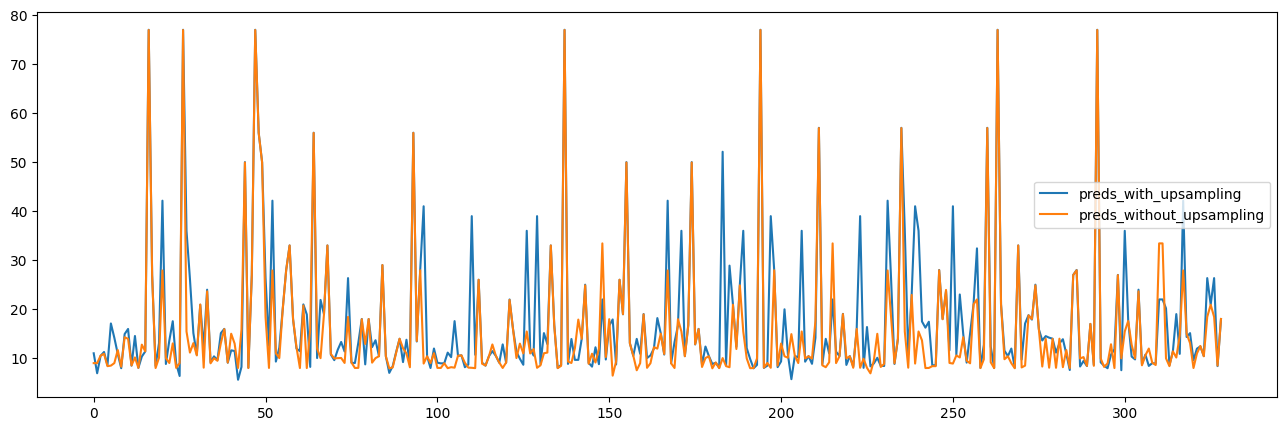

In [444]:
df_pred[['preds_with_upsampling','preds_without_upsampling']].plot(figsize=[16,5])

In [457]:
df_pred['err'] = np.absolute(df_pred['true'] - df_pred['preds_without_upsampling'])
df_pred['err_upsampling'] = np.absolute(df_pred['true'] - df_pred['preds_with_upsampling'])
df_pred

,preds_with_upsampling,true,Carrier,City,Weight,Year,Month,Day,DayOfWeek,preds_without_upsampling,err,err_upsampling
0,10.349873,10,F,Riyadh,50.000,2021,12,28,1,10.509542,0.509542,0.349873
1,9.880827,8,G,Jeddah,4.000,2022,2,7,0,7.964417,0.035583,1.880827
2,13.029472,12,D,Dammam,0.250,2021,9,25,5,11.990697,0.009303,1.029472
3,14.949663,15,A,Makkah,20.350,2023,4,18,1,14.894686,0.105314,0.050337
4,32.995399,33,V,Riyadh,4.500,2023,2,4,5,33.006496,0.006496,0.004601
...,...,...,...,...,...,...,...,...,...,...,...,...
270,7.994075,8,B,Madinah,0.410,2023,10,30,0,8.030346,0.030346,0.005925
271,8.172361,9,K,Jeddah,4.500,2023,8,2,2,8.558902,0.441098,0.827639
272,11.709902,12,P,Riyadh,1.218,2022,7,30,5,10.555801,1.444199,0.290098
273,9.675051,8,K,Jeddah,6.671,2022,7,30,5,9.905992,1.905992,1.675051


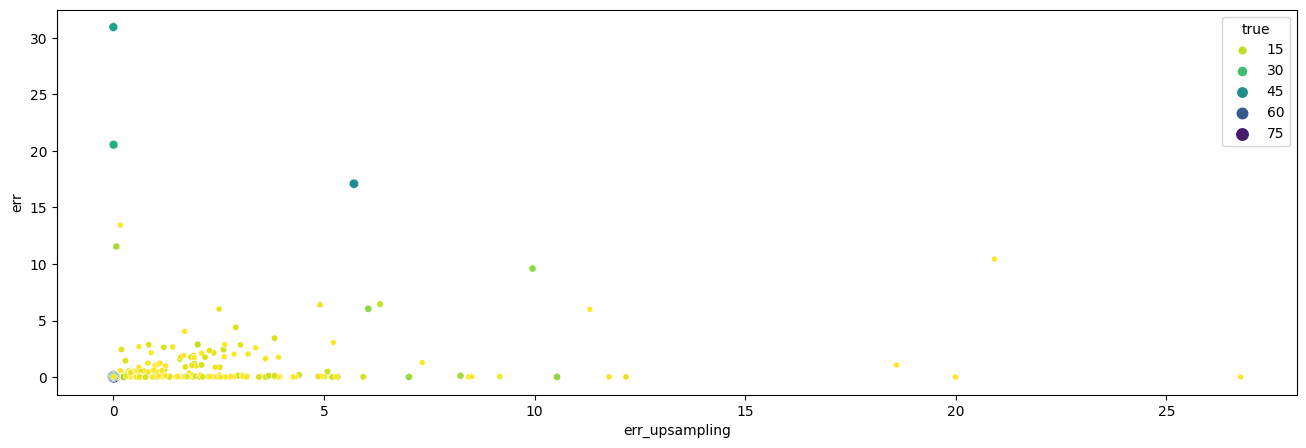

In [458]:
plt.figure(figsize=[16,5])
sns.scatterplot(data=df_pred, x="err_upsampling", y="err", size="true", hue="true", palette='viridis_r');

In [448]:
df_pred

,preds_with_upsampling,true,Carrier,City,Weight,Year,Month,Day,DayOfWeek,preds_without_upsampling,err,err_upsampling
0,11.009459,9,D,Makkah,1.020,2021,7,15,3,9.002629,0.002629,2.009459
1,6.934319,9,S,Jeddah,15.196,2023,4,20,3,9.000518,0.000518,2.065681
2,10.483289,10,K,Makkah,4.500,2023,8,3,3,10.521368,0.521368,0.483289
3,11.277307,11,K,Dammam,0.700,2021,8,8,6,10.902880,0.097120,0.277307
4,8.569440,8,K,Jeddah,4.500,2023,8,1,1,8.387036,0.387036,0.569440
...,...,...,...,...,...,...,...,...,...,...,...,...
324,26.345381,29,D,Jeddah,4.500,2023,10,2,0,18.435270,10.564730,2.654619
325,20.939167,21,K,Jeddah,1.218,2022,9,6,1,20.916365,0.083635,0.060833
326,26.345381,29,D,Jeddah,4.500,2023,10,2,0,18.435270,10.564730,2.654619
327,8.397020,9,C,Madinah,1.000,2021,7,17,5,8.506571,0.493429,0.602980


In [461]:
1 - (rmse / df_pred['true'].mean())

0.7343176290283843

In [535]:
df_fast['Delivery Duration'].value_counts()

Delivery Duration
1    58897
0    40770
2    38303
3    16637
4     6482
5     2631
6     1308
7      790
Name: count, dtype: int64

In [536]:
df_slow['Delivery Duration'].value_counts()

Delivery Duration
8     408
9     223
10    176
11    122
12     97
13     55
14     26
15     21
18     19
16     17
17     17
19     10
21      9
24      6
23      5
20      5
35      3
29      2
33      2
22      2
27      1
80      1
41      1
77      1
25      1
28      1
36      1
39      1
57      1
50      1
26      1
56      1
45      1
Name: count, dtype: int64

In [539]:
!pip install catboost
from catboost import CatBoostRegressor,CatBoostClassifier, Pool
# initialize Pool
train_pool = Pool(X_train,
                  y_train,
                  cat_features=[0,1,3,4,5,6])
test_pool = Pool(X_test,
                 y_test,
                 cat_features=[0,1,3,4,5,6])

# specify the training parameters
model = CatBoostRegressor(#iterations=2,
                          #depth=2,)
#                             loss_function='MultiClass'
)
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)
print(preds)

Learning rate set to 0.088732
0:	learn: 1.5658462	total: 120ms	remaining: 1m 59s
1:	learn: 1.5400103	total: 238ms	remaining: 1m 58s
2:	learn: 1.5150285	total: 324ms	remaining: 1m 47s
3:	learn: 1.4948692	total: 415ms	remaining: 1m 43s
4:	learn: 1.4760769	total: 488ms	remaining: 1m 37s
5:	learn: 1.4563838	total: 577ms	remaining: 1m 35s
6:	learn: 1.4375367	total: 684ms	remaining: 1m 37s
7:	learn: 1.4229948	total: 766ms	remaining: 1m 34s
8:	learn: 1.4085621	total: 840ms	remaining: 1m 32s
9:	learn: 1.3983585	total: 913ms	remaining: 1m 30s
10:	learn: 1.3882050	total: 983ms	remaining: 1m 28s
11:	learn: 1.3792963	total: 1.05s	remaining: 1m 26s
12:	learn: 1.3717303	total: 1.12s	remaining: 1m 25s
13:	learn: 1.3650452	total: 1.2s	remaining: 1m 24s
14:	learn: 1.3587177	total: 1.28s	remaining: 1m 23s
15:	learn: 1.3531777	total: 1.35s	remaining: 1m 22s
16:	learn: 1.3484331	total: 1.42s	remaining: 1m 22s
17:	learn: 1.3441517	total: 1.5s	remaining: 1m 21s
18:	learn: 1.3396625	total: 1.58s	remaining: 1

113:	learn: 1.2374339	total: 10.8s	remaining: 1m 24s
114:	learn: 1.2368837	total: 10.9s	remaining: 1m 23s
115:	learn: 1.2365589	total: 11s	remaining: 1m 23s
116:	learn: 1.2359678	total: 11.1s	remaining: 1m 23s
117:	learn: 1.2355622	total: 11.2s	remaining: 1m 23s
118:	learn: 1.2353591	total: 11.3s	remaining: 1m 23s
119:	learn: 1.2352393	total: 11.4s	remaining: 1m 23s
120:	learn: 1.2347700	total: 11.5s	remaining: 1m 23s
121:	learn: 1.2347509	total: 11.6s	remaining: 1m 23s
122:	learn: 1.2342356	total: 11.7s	remaining: 1m 23s
123:	learn: 1.2340595	total: 11.8s	remaining: 1m 23s
124:	learn: 1.2338222	total: 11.9s	remaining: 1m 23s
125:	learn: 1.2336925	total: 12s	remaining: 1m 23s
126:	learn: 1.2334472	total: 12.1s	remaining: 1m 23s
127:	learn: 1.2331461	total: 12.2s	remaining: 1m 23s
128:	learn: 1.2330301	total: 12.3s	remaining: 1m 23s
129:	learn: 1.2328303	total: 12.4s	remaining: 1m 22s
130:	learn: 1.2321399	total: 12.5s	remaining: 1m 22s
131:	learn: 1.2319149	total: 12.6s	remaining: 1m 2

270:	learn: 1.2091287	total: 26s	remaining: 1m 9s
271:	learn: 1.2091048	total: 26.1s	remaining: 1m 9s
272:	learn: 1.2086067	total: 26.2s	remaining: 1m 9s
273:	learn: 1.2084778	total: 26.3s	remaining: 1m 9s
274:	learn: 1.2084093	total: 26.4s	remaining: 1m 9s
275:	learn: 1.2082199	total: 26.5s	remaining: 1m 9s
276:	learn: 1.2082028	total: 26.6s	remaining: 1m 9s
277:	learn: 1.2081252	total: 26.7s	remaining: 1m 9s
278:	learn: 1.2077981	total: 26.8s	remaining: 1m 9s
279:	learn: 1.2076491	total: 26.8s	remaining: 1m 9s
280:	learn: 1.2075566	total: 26.9s	remaining: 1m 8s
281:	learn: 1.2074914	total: 27s	remaining: 1m 8s
282:	learn: 1.2074736	total: 27.1s	remaining: 1m 8s
283:	learn: 1.2074614	total: 27.2s	remaining: 1m 8s
284:	learn: 1.2074214	total: 27.3s	remaining: 1m 8s
285:	learn: 1.2074006	total: 27.4s	remaining: 1m 8s
286:	learn: 1.2073812	total: 27.5s	remaining: 1m 8s
287:	learn: 1.2073750	total: 27.6s	remaining: 1m 8s
288:	learn: 1.2071471	total: 27.7s	remaining: 1m 8s
289:	learn: 1.20

431:	learn: 1.1944725	total: 42.4s	remaining: 55.8s
432:	learn: 1.1943935	total: 42.5s	remaining: 55.7s
433:	learn: 1.1943776	total: 42.6s	remaining: 55.6s
434:	learn: 1.1943637	total: 42.8s	remaining: 55.5s
435:	learn: 1.1942826	total: 42.9s	remaining: 55.4s
436:	learn: 1.1942707	total: 42.9s	remaining: 55.3s
437:	learn: 1.1942159	total: 43.1s	remaining: 55.3s
438:	learn: 1.1941830	total: 43.2s	remaining: 55.2s
439:	learn: 1.1941401	total: 43.3s	remaining: 55.1s
440:	learn: 1.1941205	total: 43.4s	remaining: 55s
441:	learn: 1.1940961	total: 43.5s	remaining: 54.9s
442:	learn: 1.1940908	total: 43.6s	remaining: 54.8s
443:	learn: 1.1940763	total: 43.7s	remaining: 54.7s
444:	learn: 1.1939936	total: 43.8s	remaining: 54.6s
445:	learn: 1.1939858	total: 43.9s	remaining: 54.5s
446:	learn: 1.1939754	total: 44s	remaining: 54.4s
447:	learn: 1.1938927	total: 44.1s	remaining: 54.3s
448:	learn: 1.1938131	total: 44.2s	remaining: 54.3s
449:	learn: 1.1937225	total: 44.3s	remaining: 54.2s
450:	learn: 1.19

592:	learn: 1.1854435	total: 59.4s	remaining: 40.8s
593:	learn: 1.1853706	total: 59.5s	remaining: 40.7s
594:	learn: 1.1853658	total: 59.6s	remaining: 40.6s
595:	learn: 1.1853596	total: 59.7s	remaining: 40.4s
596:	learn: 1.1853526	total: 59.7s	remaining: 40.3s
597:	learn: 1.1853457	total: 59.8s	remaining: 40.2s
598:	learn: 1.1852468	total: 59.9s	remaining: 40.1s
599:	learn: 1.1851815	total: 1m	remaining: 40s
600:	learn: 1.1849978	total: 1m	remaining: 39.9s
601:	learn: 1.1849558	total: 1m	remaining: 39.8s
602:	learn: 1.1848958	total: 1m	remaining: 39.7s
603:	learn: 1.1848335	total: 1m	remaining: 39.6s
604:	learn: 1.1848075	total: 1m	remaining: 39.5s
605:	learn: 1.1847075	total: 1m	remaining: 39.4s
606:	learn: 1.1846936	total: 1m	remaining: 39.3s
607:	learn: 1.1845806	total: 1m	remaining: 39.2s
608:	learn: 1.1845356	total: 1m	remaining: 39.2s
609:	learn: 1.1845072	total: 1m 1s	remaining: 39.1s
610:	learn: 1.1844232	total: 1m 1s	remaining: 39s
611:	learn: 1.1843920	total: 1m 1s	remaining: 

751:	learn: 1.1769973	total: 1m 16s	remaining: 25.1s
752:	learn: 1.1769725	total: 1m 16s	remaining: 25s
753:	learn: 1.1767889	total: 1m 16s	remaining: 24.9s
754:	learn: 1.1767840	total: 1m 16s	remaining: 24.8s
755:	learn: 1.1767193	total: 1m 16s	remaining: 24.7s
756:	learn: 1.1766987	total: 1m 16s	remaining: 24.6s
757:	learn: 1.1766565	total: 1m 16s	remaining: 24.5s
758:	learn: 1.1766046	total: 1m 16s	remaining: 24.4s
759:	learn: 1.1765485	total: 1m 16s	remaining: 24.3s
760:	learn: 1.1765436	total: 1m 16s	remaining: 24.2s
761:	learn: 1.1764899	total: 1m 17s	remaining: 24.1s
762:	learn: 1.1764661	total: 1m 17s	remaining: 24s
763:	learn: 1.1763569	total: 1m 17s	remaining: 23.9s
764:	learn: 1.1763462	total: 1m 17s	remaining: 23.8s
765:	learn: 1.1763446	total: 1m 17s	remaining: 23.7s
766:	learn: 1.1763376	total: 1m 17s	remaining: 23.6s
767:	learn: 1.1763259	total: 1m 17s	remaining: 23.5s
768:	learn: 1.1762862	total: 1m 17s	remaining: 23.4s
769:	learn: 1.1762752	total: 1m 18s	remaining: 23.

908:	learn: 1.1711414	total: 1m 33s	remaining: 9.32s
909:	learn: 1.1710849	total: 1m 33s	remaining: 9.22s
910:	learn: 1.1710728	total: 1m 33s	remaining: 9.12s
911:	learn: 1.1710664	total: 1m 33s	remaining: 9.02s
912:	learn: 1.1710335	total: 1m 33s	remaining: 8.92s
913:	learn: 1.1709914	total: 1m 33s	remaining: 8.82s
914:	learn: 1.1709747	total: 1m 33s	remaining: 8.71s
915:	learn: 1.1709725	total: 1m 33s	remaining: 8.62s
916:	learn: 1.1709096	total: 1m 34s	remaining: 8.51s
917:	learn: 1.1708904	total: 1m 34s	remaining: 8.41s
918:	learn: 1.1708810	total: 1m 34s	remaining: 8.31s
919:	learn: 1.1708589	total: 1m 34s	remaining: 8.21s
920:	learn: 1.1707779	total: 1m 34s	remaining: 8.11s
921:	learn: 1.1707558	total: 1m 34s	remaining: 8.01s
922:	learn: 1.1707232	total: 1m 34s	remaining: 7.91s
923:	learn: 1.1707127	total: 1m 34s	remaining: 7.8s
924:	learn: 1.1706956	total: 1m 35s	remaining: 7.7s
925:	learn: 1.1706760	total: 1m 35s	remaining: 7.6s
926:	learn: 1.1703573	total: 1m 35s	remaining: 7.

In [540]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, preds, squared=False))

1.1449581235950972


In [541]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_train, model.predict(train_pool), squared=False))

1.1553658627987147


In [547]:
y = df['Delivery Duration']
X = df.drop('Delivery Duration', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.1542509919542023


In [544]:
rmse = mean_squared_error(y_train, xgb_model.predict(X_train), squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.0849287696887222
